# Manuscripts


We scrape the following two websites to get the manuscripts

- [IMSDb](http://www.imsdb.com/)
- [IMSDb movie scripts](https://figshare.com/projects/imsdb_movie_scripts/18907)


## The idea

The initial idea was to find manuscripts for most of the 5000 movies that we have information about from the Kaggle dataset. We then intended to analyse these manuscripts and calculate similarities between movies and calculate sentiment score for each movie. We then wanted to use the information as two variables in our recommendation engine. This was our initial plan and we spent a lot of time trying to find a solid manuscript dataset which would fulfill our requirements. To make a long story short we did not manage to find that kind of dataset. What we then did is that we created a script that downloaded all of the manuscripts in [The Internet Movie Script Database](http://www.imsdb.com/). The total amount of manuscripts in the database is only 1116 and the intersection with our movies from the Kaggle dataset is 715 manuscripts. Therefore we only manage to find manuscript for 715 movies out of the 5000 movies that we have in our dataset. It was clear to us that we where not able to use this in our recommendation engine because we did not have information about each movie in the database. What we did instead is to scrape the movies' storylines from IMDb and use similarity measures on them as a variable into our recommendation engine but you can read more about that in the recommendation engine notebook.

But we got manuscripts for 715 movies and we still thought it would be fun and interesting to analyse these manuscripts and that is exactly what we did. In this section we will try to answer the following questions

  - How is the happiness rank distribution of these manuscripts?
  - What are the 10 'unhappiest manuscripts' and what are the 10 'happiest  manuscripts'?
  - Is there a correlation between imdb ranking and happiness rank?
  - Is there a correlation between movie revenue and happiness rank? 
  - Is there a difference in a happiness rank between different movie's genres?
  - Is there a difference in the variance of the sentiment values between different movie's genres?
  - What directors direct the 'happiest' movies on average and what directors direct 'unhappiest' movies on average?
  - Use TF/IDF to figure out what words are important for each genre and then visualize that in a wordcloud.
  - Use a wordcloud to visualize the keywords for each genre of movies, remember that the Kaggle database provides information about keywords for each movie in the database.
  
  **Note:**  Happiness rank means the mean sentiment value of the manuscript

In [1]:
# lets start by getting the data
import csv
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import json
import re
import os
import matplotlib.pyplot as plt
import matplotlib as mpl 
import operator
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import operator
from math import log10, floor
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [2]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "tmdb_5000_credits.csv"
tmdb_5000_credits = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_credits[row["title"]] = row
        tmdb_5000_credits[row["title"]]['cast'] = json.loads(tmdb_5000_credits[row["title"]]['cast'])
        tmdb_5000_credits[row["title"]]['crew'] = json.loads(tmdb_5000_credits[row["title"]]['crew'])

In [3]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "tmdb_5000_movies.csv"
tmdb_5000_movies = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_movies[row["title"]] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_movies[row["title"]]['genres'] = json.loads(tmdb_5000_movies[row["title"]]['genres'])
        tmdb_5000_movies[row["title"]]['keywords'] = json.loads(tmdb_5000_movies[row["title"]]['keywords'])
        tmdb_5000_movies[row["title"]]['production_companies'] = json.loads(tmdb_5000_movies[row["title"]]['production_companies'])
        
for title in sorted(tmdb_5000_movies.keys()):
    title = title.replace(" ","-").replace("(","").replace(")","")

In [4]:
# There are some movies that either did not have imdb rating or had some information missing from the kaggle database.
# We handle these cases just by deleting those movies
movies_to_delete =[
    'National Lampoon’s Van Wilder',
    'Bran Nue Dae',
    'Pokémon: Spell of the Unknown',
    'Alien³',
    'Guten Tag, Ramón'
]

Delete movies that we decided to not include in our analysis. This was done because these movies do not have IMDb scores or there where some information lacking in the Kaggle dataset for these movies.

In [5]:
for movie in movies_to_delete:
    del tmdb_5000_credits[movie]
    del tmdb_5000_movies[movie]

## Get scripts from .txt files 


Fetching the scripts from the hard drive and check if the corresponding movie is a part of our main database. We want to find the size of the intersection to our database. In other words the number of scripts that correspond to a movie in our taggle database

In [6]:
filepath_scripts =  "scripts/"


# A python dictionary that maintains the information what movie has a manuscript in our database
manuscripts = defaultdict(bool)

for title in sorted(tmdb_5000_credits.keys()):
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","").replace(":","")
    filename = filepath_scripts + title_for_uri + ".txt"
    try:
        #print (filename)
        f = open(filename,"r")
        manuscripts[title] = True
    except:
        manuscripts[title] = False

## Check intersection

We only want to make analysis on the movies that are part of the kaggle database. Therefore we start by finding the intersection between the scripts database and the Kaggle dataset. In other words we want to find the movies that are a part of both datasets.

In [7]:
manuscripts_intersection = [key for key,value in manuscripts.items() if value == True]

In [8]:
print("Number of movies that are in both databases is: {} movies".format(len(manuscripts_intersection)))

Number of movies that are in both databases is: 715 movies


## Time span of movies
Next we wanted to see the timespan of these 715 movies that have manuscripts.

In [9]:
movies_with_manuscripts = [(key, tmdb_5000_movies[key]["release_date"].split("-")[0] ) 
                           for key,value in manuscripts.items() if value == True]

mwm_year_dist = Counter([year for _,year in movies_with_manuscripts])

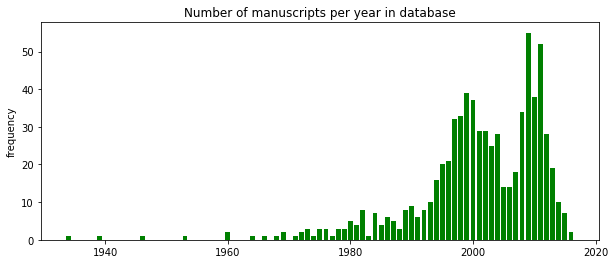

In [10]:
keys_as_int = [int(x) for x in mwm_year_dist.keys()]
plt.figure(figsize=(10,4))
plt.bar(keys_as_int, mwm_year_dist.values(), color="green")
plt.ylabel("frequency")
plt.title("Number of manuscripts per year in database")
plt.show()

It can be seen here above that most of the manuscripts are from the period 1990 until 2015. 

# Sentiment Analysis

Now we have the scripts ready to do our sentiment analysis of the manuscripts. The first thing that is done is to get the happyness rank from the LabMT wordlist.  It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1).

We start of by getting the average happiness of each word in Data set S1 into a dictionary. We do this by reading the dataset line by line and put each line (except the first 4 lines) into a dictionary.

The dataset as well as more information about how the average happiness value of each word in the dataset is calculated can be found by clicking on the following [link](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s2).

In [11]:
from collections import defaultdict

# counter to count the number of lines that have been processed
counter = 0

happyness_rank = defaultdict(float)
path = 'Data_Set_S1.txt'
with open(path) as f:
    for line in f:
        counter += 1
        
        # we want to skip the first 4 lines of the file
        if counter > 4:
            line = line.split()
            word = line[0]  # get the word from the line
            happiness_average = float(line[2]) # get the word happiness average
            happyness_rank[word] = happiness_average

In [12]:
import numpy as np

from __future__ import division

# Takes in a list of tokens and the happiness_keys which is the list of words in data set 1
# returns the mean value of the happiness rank that was found in the tokens array and
# the variance of the happiness rank
# if no value was found then the function returns None
def estimateHappiness(tokens,happiness_keys):
    
    happiness_avg = [] # an array that contains the average happyness values of the tokens
    
    for token in tokens:
        # only include the words that can be found in the data set
        if token in happiness_keys: 
            happiness_avg.append(happyness_rank[token])
            
    # If no word in the tokens array is found in the dataset then we return 0
    if len(happiness_avg) == 0:
        return None
    else : 
        return np.mean(happiness_avg),np.var(happiness_avg)

Next we calculate the mean happiness rank for each manuscript. We did some minor preprocessing of each manuscript, each manuscript contains scene headings that we did not consider to be important. Therefore we excluded those lines from the sentiment analysis. 

In [13]:
filepath_scripts =  "scripts/"


happiness_keys = set(happyness_rank.keys())

# Create a dictionary that is a container for the sensitivity analysis values
happiness_score = defaultdict(float)
happiness_var = defaultdict(float)

counter = 0
for title in manuscripts_intersection:
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","").replace(":","")
    filename = filepath_scripts + title_for_uri + ".txt"
    
    with open(filename) as f:
        movie_text_tokens = []

        for line in f.readlines():
            # Clean the text by eliminating punctations 
            translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
            line = line.translate(translator)

            # We decided to eliminate sentances if it only contains upper case letters. 
            # because we did not want to include the scene headings
            if not line.isupper():
                line = line.lower() # make the whole line lower case
                line = line.split()

                # Take out the empty lines
                if line:
                    for word in line:
                        movie_text_tokens.append(word)
                        
        avg_happiness, var_happiness = estimateHappiness(movie_text_tokens,happiness_keys)

        happiness_score[title] = avg_happiness
        happiness_var[title] = var_happiness

        counter += 1

** Save the result to a file**

In [14]:
result_file_uri = "happiness-score.json"

with open(result_file_uri, 'w') as fp:
    json.dump(happiness_score, fp)


## Pre-analyzing the result

We start our analysis by plotting the mean sentiment score for all of the 715 movie scripts that we are going to analyze.

In [15]:
y, x = np.histogram(list(happiness_score.values()),100)

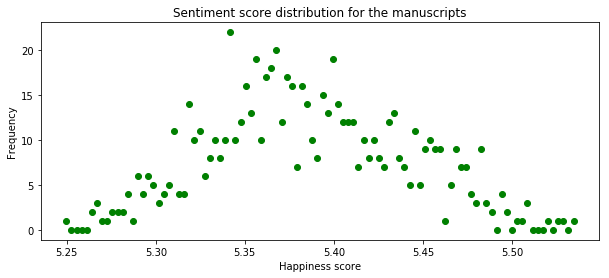

The mean sentiment score: 5.3937


In [16]:
plt.figure(figsize=(10,4))
plt.plot(x[0:-1], y, 'o', color="green",)
plt.title("Sentiment score distribution for the manuscripts")
plt.ylabel("Frequency")
plt.xlabel("Happiness score")
plt.show()

print("The mean sentiment score: {}".format( round_sig(np.mean(x), sig=5)))

- It can be seen that the average sentiment or happiness score of the movies forms a distribution that looks a lot like normal distribution. The values are all within quite a narrow range, which is understandable because we are calculating the average sentiment of the movies over a whole manuscript. Therefore the values will all be dragged towards the average happyness score of the LabMT wordlist. However, the results still has some variance and we will analyse the difference further here down below. 
- It is interesting to see that the distribution seems to be in line with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). 
- We decided to not delete the stopwords from the token list of each manuscript, the reason being that the LabMT wordlist contains stopwords and therefore, in our opinion, it does not make sense to exclude the informtion that the stopwords contain.

**The ten 'happiest scripts'**

It is interesting to see what ten movies have the happiest vocabulary on average.

In [17]:
ten_happiest = sorted(happiness_score.items(), key=operator.itemgetter(1), reverse=True)[0:10]

print ("{movie_s: <35} {sentimentscore_s: <16} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentscore_s = "Avg. score", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_happiest:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentscore_s: <16}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentscore_s = round_sig(value,5),
            genre_s = genres
        ))


Movie                               Avg. score       Genres         
---------------------------------------------------------------------------------
Mary Poppins                        5.5375            Comedy Family Fantasy 
Boyhood                             5.5303            Drama         
Bridesmaids                         5.5273            Comedy Romance 
Her                                 5.5222            Romance Science Fiction Drama 
The Family Man                      5.5103            Comedy Drama Romance Fantasy 
Napoleon Dynamite                   5.5102            Comedy        
Precious                            5.5094            Drama         
The Perks of Being a Wallflower     5.5082            Drama Romance 
Rachel Getting Married              5.5039            Drama         
It's Complicated                    5.4989            Comedy Romance 


The result is not surprising and quite understandable. It can be seen that the movies with the highest average sentiment score are all so called "feel good movies" that we would beforehand expect to have quite happy vocabulary. This is something that we expected and it is nice to see that the result is in line with our intuition.

**The ten 'unhappiest scripts'**

It is also interesting to see what ten movies have the "unhappiest" vocabulary on average.

In [18]:
ten_unhappiest = sorted(happiness_score.items(), key=operator.itemgetter(1), reverse=False)[0:10]

print ("{movie_s: <35} {sentimentscore_s: <16} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentscore_s = "Avg. score", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_unhappiest:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentscore_s: <16}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentscore_s = round_sig(value,5),
            genre_s = genres
        ))

Movie                               Avg. score       Genres         
---------------------------------------------------------------------------------
Army of Darkness                    5.2498            Fantasy Horror Comedy 
Blade II                            5.265             Fantasy Horror Action Thriller 
Dawn of the Dead                    5.2655            Fantasy Horror Action 
Resident Evil                       5.268             Horror Action Science Fiction 
Predator                            5.2687            Science Fiction Action Adventure Thriller 
Cliffhanger                         5.269             Action Adventure Thriller 
Day of the Dead                     5.2699            Horror Science Fiction 
Alone in the Dark                   5.2748            Action Fantasy Horror Thriller 
The Thing                           5.2767            Horror Mystery Science Fiction 
Conan the Barbarian                 5.2769            Adventure Fantasy Action 


Again the result is again as expected. The movies with the 'unhappiest' manuscript vocabulary are all movies that we could easily expect to have a negative vocabulary. These are all action or horror movies where the main storyline of the movie evolves around death or war.

** The variance of the sentiment score **

When calculating the average sentiment score for all of the 715 movie scripts we also calculated the variance of the sentiment values for each movie. This value will give us some sense of how diverse the vocabulary is that is used in the movies. It could be an interesting thing to investigate a little bit further. 

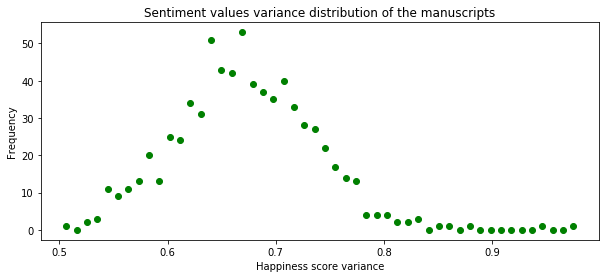

The mean sentiment variance: 0.74557
The max variance is 0.98482
The min variance is 0.50632


In [19]:
y, x = np.histogram(list(happiness_var.values()),50)

plt.figure(figsize=(10,4))
plt.plot(x[0:-1], y, 'o', color="green",)
plt.title("Sentiment values variance distribution of the manuscripts")
plt.ylabel("Frequency")
plt.xlabel("Happiness score variance")
plt.show()

print("The mean sentiment variance: {}".format( round_sig(np.mean(x), sig=5)))
print("The max variance is {}".format(round_sig(max(x), sig=5)))
print("The min variance is {}".format(round_sig(min(x), sig=5)))

There is not much that is specially interesting to see here, there seems to be some differences in the variance of the sentiment values between the manuscripts. To further investigate this we decided to write out the 10 movies with the least variance in the sentiment values of their manuscript and vice versa for the 10 movies with the most variance. 

In [20]:
ten_mostvar = sorted(happiness_var.items(), key=operator.itemgetter(1), reverse=True)[0:10]

print("The movies with the most variance in the manuscript's sentiment values\n")

print ("{movie_s: <35} {sentimentvar_s: <26} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentvar_s = "Sentiment score variance", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_mostvar:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentvar_s: <26}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentvar_s = round_sig(value,5),
            genre_s = genres
        ))

    
print("\nThe movies with the least variance in the manuscript's sentiment values\n")

ten_leastvar = sorted(happiness_var.items(), key=operator.itemgetter(1), reverse=False)[0:10]

print ("{movie_s: <35} {sentimentvar_s: <26} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentvar_s = "Sentiment score variance", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_leastvar:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentvar_s: <26}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentvar_s = round_sig(value,5),
            genre_s = genres
        ))

The movies with the most variance in the manuscript's sentiment values

Movie                               Sentiment score variance   Genres         
---------------------------------------------------------------------------------
Cecil B. Demented                   0.98482                     Thriller Comedy Crime 
Serial Mom                          0.95264                     Comedy Crime Horror Thriller 
Interview with the Vampire          0.88287                     Horror Romance 
Robin Hood: Prince of Thieves       0.86571                     Adventure     
Legend                              0.85656                     Crime Thriller 
The Doors                           0.83921                     Drama Music   
Deadpool                            0.83538                     Action Adventure Comedy 
The Fault in Our Stars              0.83286                     Romance Drama 
Little Nicky                        0.82938                     Comedy Fantasy Romance 
Coriolanus  

Here we get some interesting results. Remember that the values reported is the variance of the sentiment values for each manuscript. This tells us something about the vocabulary of the movie. For example if a movie has a big variance in the sentiment values of its manuscript then the vocabulary used in the manuscript must be quite diversed, meaning that that there must be a lot of happy words used and also a lot of non happy words. 

That being said, if you look at the top 10 movies with the most variance, most of these movies are movies that are both considered a Thriller/Action/Crime/Horror and a Comedy/Romance. All of these movies both are sad and happy at the same time meaning that the storyline has a lot of variance within the sentiment. Like for example the movie Deadpool; it is a dark comedy which is also consider to be a action or a adventure movie. Deadpool is a comedy that contains a lot of violence and so it is understandable that the happyness rank of the words used in the manuscript vary alot. Most of the other movies in the top ten lists are all similar movies in that way, The Fault in Our Stars is for example a romantic movie about two teenagers that both have cancer. The movie is both sad and romantic in the same time therfore the movie's manuscript contains a lot of unhappy words which corresponds to the sad part of the movie and a lot of happy words which corresponds to the happy part of the movie. 

The bottom 10 list are all movies that is either about something happy, like comedies or romance movies or they are on the darker side of spectrum meaning that the storyline is about something which can be considered unhappy, like Horror movies, dark Drama movies or dark Action/Thriller movies. Therefore the sentimental value of the words used in the manuscript do not vary as much.

This is something that one could have expected but is quite nice to be able to see this from the sentiment analysis of the manuscripts. 

After these finding we wanted to see if there was a difference in the mean variance between movie genres and we will investigate that in the section **Sentiment per movie genre **

## Sentiment vs Success of a movie 

To further analyze the sentiment, we wanted to find out if the sentiment has something to do with the success of the movie. We defined the success as both the total revenue earned by the movie and also the movie's IMDb score. To investigate this we simply checked if there was any correlation between firstly the sentiment of each movie versus the IMDb score of the movie and secondly if there we a correlation between the sentiment and the total revenue earned by the movie.

** First we get the IMDb rating for each movie **

In [21]:
# We use the fact that we know that each movie has a name, so we do not include any error handling
def findMovieNameFromId(id):
    name = [key for key,info in tmdb_5000_movies.items() if info['id'] == id]
    return name[0]

In [22]:
result_file_uri = "imdb-score-mod-mod.json"

# Getting Imdb scores from data and convert the id to name 
with open(result_file_uri) as json1_file:
    json1_str = json1_file.read()
    Imdb_5000_movies_withid = json.loads(json1_str)

Imdb_5000_movies = defaultdict(float)

# change the dictionary key from id to name of the movie
for key,value in Imdb_5000_movies_withid.items():
    try: 
        name = findMovieNameFromId(key)
        Imdb_5000_movies[name] = float(value)
    except: 
        print("The movie {} has been removed from kaggle database".format(key))


The movie 38415 has been removed from kaggle database
The movie 11452 has been removed from kaggle database
The movie 10991 has been removed from kaggle database
The movie 242575 has been removed from kaggle database
The movie 8077 has been removed from kaggle database


** Movie rating vs. script sentiment**

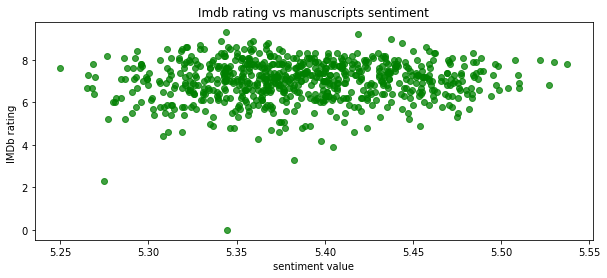

The correlation between the IMDb rating and the sentiment is : 0.074237


In [23]:
movieRating_vs_sentiment = [(float(Imdb_5000_movies[key]),happiness_score) for key, happiness_score in happiness_score.items()
                           if Imdb_5000_movies[key] != None]
y,x =  zip(*movieRating_vs_sentiment)

plt.figure(figsize=(10,4))
plt.plot(x, y, 'o', color="green", alpha = 0.75)
plt.title("Imdb rating vs manuscripts sentiment")
plt.ylabel("IMDb rating ")
plt.xlabel("sentiment value")
plt.show()


print("The correlation between the IMDb rating and the sentiment is : {}".format(round_sig(np.corrcoef(x,y)[1][0],5)))

- There does not seem to be any correlation between movie's IMDb rating and the sentiment of the movie's script. These findings are quite surprising, at least from our point of view. Before doing the analysis we expected to see a slightly positive correlation because many of the highly rated movies are somewhat dramatic movies that tend to use intense language. At least that was our initial intuition and we expected higly rated movies to have slightly lower sentiment values, in most cases.  

- We know that there does not seem to be any correlation between the movie's IMDb rating and the sentiment of the movie's script but we wanted to investigate the outliers on the opposite side of the IMDb ranking a bit further by looking at the 10 highest and lowest ranked movies and their sentiment values.

**Visualize the 10 highest and lowest ranked movies (that we have in our manuscript dataset) and their sentiment values **

In [24]:
# visualize the the 10 highest and lowest ranked movies (that we have in our manuscript database) 
# and their sentiment values

ten_highestranked = []
ten_lowestranked = []

n = 10 
i = 0
imdb_ranking_sorted = sorted(Imdb_5000_movies.items(), key=operator.itemgetter(1),reverse = True)
while True:
    if len(ten_highestranked) != 10:
        if imdb_ranking_sorted[i][0] in list(happiness_score.keys()):
            ten_highestranked.append(imdb_ranking_sorted[i])
    else:
        break
    i = i + 1

n = 10 
i = 0
imdb_ranking_sorted = sorted(Imdb_5000_movies.items(), key=operator.itemgetter(1),reverse = False)
while True:   
    if len(ten_lowestranked) != 10:
        if imdb_ranking_sorted[i][0] in list(happiness_score.keys()):    
                ten_lowestranked.append(imdb_ranking_sorted[i])
    else:
        break
    i = i + 1

In [25]:
# let's visualize the findings

print ("The 10 highest ranked movies in our manuscript database\n")

print ("{movie_s: <50} {imdbscore_s: <16} {sentimentscore_s: <14} ".format(
    movie_s = "Movie", imdbscore_s = "IMDb rating", sentimentscore_s = "Avg. score"))

print ("---------------------------------------------------------------------------------")

sentiment_values = []
for key,value in ten_highestranked:     
    # add the sentiment value to a array to be able to calculate the mean in the end
    sentiment_values.append(happiness_score[key])
    
    print ("{movie_s: <50} {imdbscore_s: <16}  {sentimentscore_s: <14}".format(
            movie_s =  key,
            imdbscore_s = value,
            sentimentscore_s = round_sig(happiness_score[key],5)
        ))

print ("---------------------------------------------------------------------------------")
print ("{mean_s: <68} {sentimentscore_s: <14}".format(
        mean_s =  "MEAN",
        sentimentscore_s = round_sig(np.mean(sentiment_values),5)
    ))

print ("\nThe 10 lowest ranked movies in our manuscript database\n")

print ("{movie_s: <50} {imdbscore_s: <16} {sentimentscore_s: <14} ".format(
    movie_s = "Movie", imdbscore_s = "IMDb rating", sentimentscore_s = "Avg. score"))

print ("---------------------------------------------------------------------------------")

sentiment_values = []
for key,value in ten_lowestranked:      
    # add the sentiment value to a array to be able to calculate the mean in the end
    sentiment_values.append(happiness_score[key])
    print ("{movie_s: <50} {imdbscore_s: <16}  {sentimentscore_s: <14}".format(
            movie_s =  key,
            imdbscore_s = value,
            sentimentscore_s = round_sig(happiness_score[key],5)
        ))
    
print ("---------------------------------------------------------------------------------")
print ("{mean_s: <68} {sentimentscore_s: <14}".format(
        mean_s =  "MEAN",
        sentimentscore_s = round_sig(np.mean(sentiment_values),5)
    ))

The 10 highest ranked movies in our manuscript database

Movie                                              IMDb rating      Avg. score     
---------------------------------------------------------------------------------
The Shawshank Redemption                           9.3               5.3442        
The Godfather                                      9.2               5.4191        
The Godfather: Part II                             9.0               5.4377        
Schindler's List                                   8.9               5.341         
Pulp Fiction                                       8.9               5.3595        
Inception                                          8.8               5.3676        
Forrest Gump                                       8.8               5.4436        
Fight Club                                         8.8               5.3576        
The Matrix                                         8.7               5.3289        
One Flew Over the Cuc

**Conclusion**

The findings here above are in line with the finding in the previous section. There does not seem to be any correlation between the sentiment value of the manuscripts and the IMDb ranking of the movie. However these analysis are based on a subset of 715 movies and therefore we cannot conclude anything. The only thing we can say is that these findings support the hypothesis that there is no correlation between IMDb ranking and sentiment value of the manuscript.

** Revenue vs movie sentiment** 

Note: Some movies in the database do not have info about the revenue, therefore the revenue is set to zero. We decided to exclude those movies from the analysis

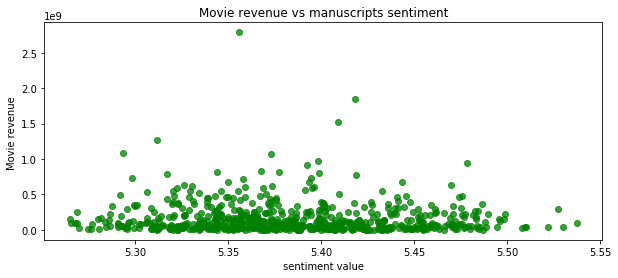

The correlation between the movie revenue and the sentiment is : -0.062089


In [26]:
movieGross_vs_sentiment = [(float(tmdb_5000_movies[key]['revenue']),happiness_score) for key, happiness_score in happiness_score.items()
                            if float(tmdb_5000_movies[key]['revenue']) != 0]

y,x =  zip(*movieGross_vs_sentiment)

plt.figure(figsize=(10,4))
plt.plot(x, y, 'o', color="green", alpha = 0.75)
plt.title("Movie revenue vs manuscripts sentiment")
plt.ylabel("Movie revenue ")
plt.xlabel("sentiment value")

plt.show()


print("The correlation between the movie revenue and the sentiment is : {}".format(round_sig(np.corrcoef(x,y)[1][0],5)))

Here it does not come as a surprise that there is no correlation between the movie revenue and the sentiment of the manuscripts. 

## Sentiment per movie genre

Is there a difference in happiness rank between different movie genres. Again these analysis are based on a subset of 715 movies and therefore we cannot say anything about how these analysis would generalize to a bigger dataset. But it is still interesting to see if there is a difference in the sentiment of the manuscripts between movies genres based on the data that we managed to gather.

We will visualize the finding both in a boxplot which shows us the variance and the median value of the mean sentiment values for the manuscripts within each genre. Then for completness we also write out the average mean sentiment value for each genre. 

In a previous section we investigated the variance of the sentiment values for each manuscript. Now we also investigate if the mean variance of the manuscripts is different between movie genres. This will give us some idea of how diverse the vocabulary is within each genre

**NOTE:** Just for clarification, in this analysis when we talk about *the average of the mean sentiment values* then we are talking about the average value of the mean sentiment values of all of the manuscripts within a genre. For example there are 8 movies in the music genre, therefore there are 8 manuscripts within the music genre. What we did is that we calculated the the mean sentiment value of the words in each of these manuscripts giving us 8 mean sentiment values. Then to calculate the average of the mean sentiment values for the music genre we simlpy calculated the average value of these 8 mean sentimental values. The same goes for *the average variance of the sentiment values*, then we are talking about the average value of the variances of the sentiment values in each manuscript in the genre.  

We start the analysis by finding all the different genres of the movies in our movie database.

In [27]:
genres = set()
genre_script_freq = defaultdict(int)
    
for key,value in happiness_score.items():
    # for each movie we add the sentimental value to all of the movies genres
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genre_script_freq[genre] += 1

genres = list(genre_script_freq.keys())

print ("{genre_s: <20} {nr_s: <14}".format(
        genre_s =  "Genre",
        nr_s = "Number of manuscripts"))

print("------------------------------------------")

for genre,nr in genre_script_freq.items():
    print ("{genre_s: <20} {nr_s: <14}".format(
        genre_s =  genre,
        nr_s = nr
    ))

Genre                Number of manuscripts
------------------------------------------
Music                9             
Western              8             
Crime                143           
Science Fiction      114           
Comedy               209           
Family               41            
Animation            28            
Action               197           
Thriller             258           
Adventure            131           
War                  22            
Horror               80            
History              30            
Drama                358           
Romance              128           
Mystery              77            
Fantasy              72            


Next we want to visualize the average mean sentiment values of the moviescripts for each genre. Each movie can have one or more genre. For this analysis we did not consider that to be a problem, we simply added the sentiment value for each moviescript into all of the genres that the movie is part of. Finally,we visualized the results in a boxplot.

We also created a table which shows us the average of the mean sentiment values for each genre as well as the average variance of the sentiment values for each genre. 

In [28]:
# Find the average sentiment value for each genre

genre_dict_mean = defaultdict(list)
genre_dict_var = defaultdict(list)
    
for key,value in happiness_score.items():
    # for each movie we add the sentimental value to all of the movies genres
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genre_dict_mean[genre].append(value)
        genre_dict_var[genre].append(happiness_var[key])

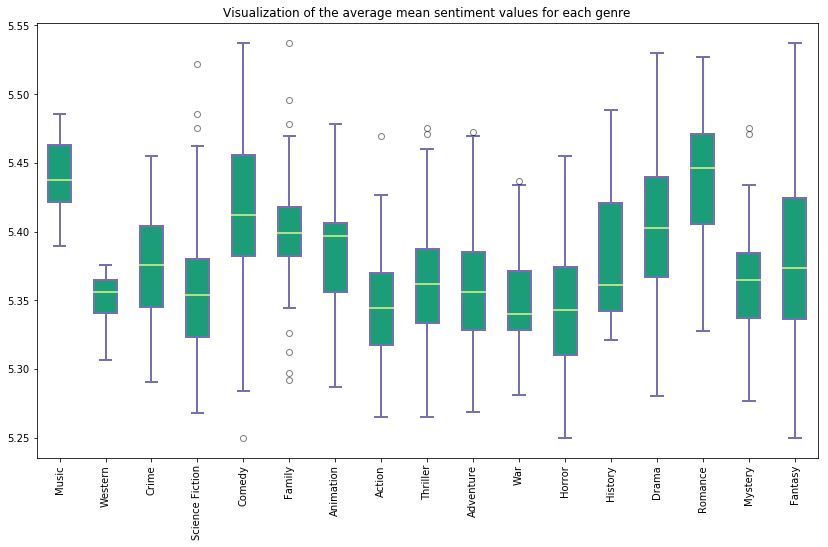

Genre                Avg. mean of Sentiment values       Avg. var of Sentiment values        Manuscripts count 
--------------------------------------------------------------------------------------------------------------
Music                5.4389                              0.71704                             9 
Romance              5.4373                              0.69245                             128 
Comedy               5.4154                              0.69378                             209 
Drama                5.4037                              0.67519                             358 
Family               5.4005                              0.68972                             41 
Animation            5.3836                              0.68864                             28 
History              5.3822                              0.68804                             30 
Fantasy              5.3811                              0.69761                             72 

In [29]:
# Visualize the findings
# We will visualize the findings in a boxplot to be able to see the variance of the mean sentiment values within each genre

x = [] # the genre name
y = [] # the sentiment values for the genres 

for key, values in genre_dict_mean.items():
    x.append(key)
    y.append(values)

# Create a figure instance
fig = plt.figure(1, figsize=(14, 8))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(y, patch_artist=True)


## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(x,rotation = "vertical")

plt.title("Visualization of the average mean sentiment values for each genre")
    
plt.show()

# Finally we write out the average value for each genre

print ("{genres_s: <20} {value_s: <35} {value2_s: <35} {nr_s} ".format(
    genres_s = "Genre", value_s = "Avg. mean of Sentiment values",value2_s =  "Avg. var of Sentiment values", nr_s = "Manuscripts count" ))

print("--------------------------------------------------------------------------------------------------------------")

genre_dict_avg = defaultdict(float)
genre_dict_avg_var = defaultdict(float)

# calculate the average of the mean sentiment values for each genre 
for key, values in genre_dict_mean.items():
    genre_dict_avg[key] = np.mean(values)
    
# calculate the average variance of the sentiment values for each genre 
for key, values in genre_dict_var.items():
    genre_dict_avg_var[key] = np.mean(values)

for key, values in sorted(genre_dict_avg.items(),key=operator.itemgetter(1), reverse=True):
    print ("{genres_s: <20} {value_s: <35} {value2_s: <35} {nr_s} ".format(
        genres_s = key, 
        value_s = round_sig(np.mean(values),5),
        value2_s = round_sig(np.mean(genre_dict_avg_var[key] ),5),
        nr_s = genre_script_freq[key]
        ))
    
    
    
    

** Some thoughts **

 - **Note:** We do not have equal amount of manuscripts for each genre, therefore the result cannot be taken as the whole truth but this still gives us a good idea of the behavior. 


 - The genres Music, Romance, Comedy, Drama and Family are the 5 genres with the highest average of the mean sentiment values like one could have expected. These genres of movies seem to have the happiest manuscripts on average based on the LabMT wordlist.
 
 - Similarly it is easy to understand why War, Western, Action and Horror movies have low mean sentiment values on average. Movies within these genres are often about the dark sides of life and therefore the moviescripts contain a lot of words that we human consider unhappy words. Words like war, guns, fights and so on.
 
 
 - The genres History, Drama, Comedy and Fantasy seem to have the most variance of the mean happyness value of the manuscripts. This shows us that these genres have diverse movies within the genre, meaning that some of the movies within the genre are considered to be sad or unhappy while other movies in the same genre are considered happy. It is trivial to agree with these findings. Let's take the History genre for example; one history movie can be about war which would be considered something sad and then there could be another history movie in the database that is about how love has changed over the years, that movie would be consider to be quite positive or happy. 
 
 - The movies Family and Western have the least variance within the average of the mean sentiment values. This is also something that we can easily agree with. Movies that are classified as family movies are most often about something that is happy, something that the whole family can watch together and are so called "feel good movies". There are not many family movies that are about something dark and unhappy and Therefore the median and the mean sentiment value is quite high for these types of movies and the variance of the mean value is low. In contrast,  western movies are nearly all about something dark; fights, war, robbery or life struggle. There are few happy western movies out there, at least we haven't seen a single one in our life.
 
- The genre Science Fiction contains the least average variance within the sentiment values of each manuscript. This came as a surprise to us. The vocabulary used in the Science Fiction's manuscripts does not vary as much between very happy words and very unhappy words like the for the other genres. 
- The genres with the highest average variance within the vocabulary of the manuscripts is Music, Romance, Comedy, Fantasy and Western. The first three genres are understandable because one can expect movies of these genres to have vocabulary that varies quite alot between happy and sad words but the genre Western caught our attention. The vocabulary used in the western movies seems to be diverse which we did not expect in the beginning but when you think about it these movies often contain some romantic stories within the storyline and therefore most often contain some amount of words that are considered to be happy.

## Sentiment analysis of directors 

We are interested in seeing what directors are directing the happiest movies on average and what directors are directing the unhappiest movies on average. Because we have limited amount of manuscripts we only considered directors that have directed more than 3 movies of the movies in our manuscript database. 

In [30]:
directors_happiness = defaultdict(list)

for key,value in happiness_score.items():
    director = [crew["name"] for crew in tmdb_5000_credits[key]['crew'] if crew["job"] == "Director"][0]
    directors_happiness[director].append(value)


In [31]:
directors_happiness_sorted = sorted([(directors, np.mean(values)) for directors,values in directors_happiness.items() if len(values) > 3], 
       key =  lambda x:x[1],
       reverse = True
    )

In [32]:
# print out top and bottom 10 directors of movies based on the happiness sentiment values of the movie's manuscripts

print("The 10 directors directing the movies with the HAPPIEST manuscripts on average \n")

print ("{director_s: <35} {sentimentscore_s: <16}".format(
    director_s = "Director", sentimentscore_s = "Avg. happyness score of manuscripts"))

print ("-----------------------------------------------------------------------")

for key,value in directors_happiness_sorted[0:10]:      
    print ("{director_s: <35} {sentimentscore_s: <16}".format(
            director_s =  key, 
            sentimentscore_s = round_sig(value,5)
        ))
    
    
print("\n\nThe 10 directors directing the movies with the UNHAPPIEST manuscripts on average \n")

print ("{director_s: <35} {sentimentscore_s: <16}".format(
    director_s = "Director", sentimentscore_s = "Avg. happyness score of manuscripts"))

print ("-----------------------------------------------------------------------")

for key,value in directors_happiness_sorted[-10:]:      
    print ("{director_s: <35} {sentimentscore_s: <16}".format(
            director_s =  key, 
            sentimentscore_s = round_sig(value,5)
        ))

The 10 directors directing the movies with the HAPPIEST manuscripts on average 

Director                            Avg. happyness score of manuscripts
-----------------------------------------------------------------------
Paul Thomas Anderson                5.4417          
Tim Burton                          5.4386          
Jonathan Demme                      5.4352          
Spike Lee                           5.4211          
Ang Lee                             5.4097          
Francis Ford Coppola                5.4096          
Harold Ramis                        5.4001          
Robert Zemeckis                     5.3945          
Steven Soderbergh                   5.3922          
David O. Russell                    5.3907          


The 10 directors directing the movies with the UNHAPPIEST manuscripts on average 

Director                            Avg. happyness score of manuscripts
-----------------------------------------------------------------------
James Cameron   

** Some thougts ** 

Here we see some of the best directors of all time. Paul Thomas Anderson has the 'happiest' movies of all the directors. We find this a bit strange as he most famous for 'There Will Be Blood' which is about some unhappy events and contains a lot of hatred. He also directed 'Magnolia' which is mainly about love so it looks like that movie outweighs the 'sadness' of 'There Will Be Blood'. Tim Burton is famous for 'weird' movies like 'Edward Scissorhands' but they're not necesarily sad. He directed 'Charlie And The Chocolate Factory' and 'Alice In Wonderland' which are considered movies suitable for kids and are overall happy movies (though they contain parts of sadness). Jonathan Demme has directed some 'dark' movies and we find it quite strange that he is amongst the ones with the 'happiest' movies. 'Silence Of The Lambs' is probably the most famous one and it is about a cannibalistic serial killer. We figure that certain scenes from his movies must drive the happiness score up. Another name from the top ten list that we find interesting is Francis Ford Coppola. He directed the famous Godfather trilogy, those movies are about mobsters trying to control their organized crimes, it may seem weird at first that he has directed among the 'happiest' movies but when you think about Godfather it is mainly about family and family is a happy word. 

Now onto the 'unhappiest' directors. James Cameron has directed several dark movies, though he may be famous now a days for 'Avatar', he directed 'Titanic' which is about a sinking ship and people dying, 'Terminator I & II' which is about evil robots taking over the world, 'Aliens' and 'Abyss'which are both dark. Michael Mann is famous for movies that involve crime, so it is understandable he is on the bottom ten list. Steven Spielberg is probably the biggest surprise on the list, his movies don't seem as dark, although he has directed movies like; 'Jaws', 'Indiana Jones Movies', 'Schindler's List' which is really sad. Wes Craven is famous for horror movies and Lilly Wachowski directed the 'Matrix' trilogy. Ridley Scott and Michael Bay have directed all sorts of movies but mainly on the 'darker' side. Christopher Nolan is one of the biggest directors now a days and his movies are dramatic, which understandable translates to a lower happiness score. John McTiernan directed 'Die Hard: I & III' and 'Predator' which are both about gunfights and contain lots of swearing. Paul W.S. Anderson directed for example the 'Resident Evil' films which are quite dark as one can deduce from the name of the franchise.

## Term Frequency of the manuscripts, words that characterize the genres

Using the Term Frequency - Inverse Document Frequency, or TF-IDF, we can figure how important a word in a manuscript is for our total collection of scripts. So by doing this we can find the words that are most important for each genre of movies in our dataset. There are 17 different movie genres in our database.

### TF - IDF

**First**, check out the wikipedia page for [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF.
    - What does TF stand for?
    - What does IDF stand for?
    
**Point of tf-idf** is to evaluate numerically how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. 

tf-idf is the product of two statistics, term frequency and inverse document frequency. Note that there are various ways for determining the exect values of both statistics.

**Term frequency** tf(t,d), the simplest choice is to use the raw count of a term in a document, i.e. the number of times that term t occurs in document d. There are some other possibilities to evaluate the term frequency which can be found in the wikipedia page. 

** Inverse document frequency** is a measure of how much information the word provides, that is, whether the term is common or rare accross all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by number of documents containing the term, and then taking the logarithm of that quotient. See [wikipage](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for detail about the equaltion.

### Word cloud

 - The package needs a string to work on. The way that I converted my TF-IDF results to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its TF-IDF score (rounded up to the nearest integer value).

 
### Procedure
The **procedure** can be described as follows
- First we collect each manuscript that is a part of each genre. We then preprocess the text by eliminating stop words and some additional words that we found out that where not important but skewed the results (words that are not part of the storyline but are words that have special meaning in manuscripts, like for example the word playbill). We then tokenized each manuscript with the nltk.regexp_tokenizer. After that we combined the tokens into one long string of tokens.  We then combine each genre's preprocessed manuscript into one huge text file. Therefore we will end up with one huge textfile for each genre. 
- Next, we calculate the TF-IDF to figure out what words are important for each genre. We choose to use the TfidfVectorizer from sci kit learn module to implement the TF-IDF matrix for these 17 huge files. 
- Then we create a word cloud based on the TF-IDF matrix. 

**Work**


First thing to do is to get all of the movies that is associated with each genre and create a huge file for each genre that contains all of the movie scripts associated with that genre. Note that some manuscripts have more than one genre so there will be some intersection between these 17 huge files, we tried a couple of methods but this method produced the best result.

In [36]:
filepath_scripts =  "scripts/"

# create a dictionary that contains the combined text string for each genre
all_genres_scripts = defaultdict(str)

# Find the stopwords in the englisth alphabet and also some additional words that are non important
stop_words = stopwords.words('english') + ["you're", "don't", "i'm", "l'm", "i'll", "should've","captain","protocol","commentator","graft","sheet","chunk","accent", "build","playbill"] # adding extra stopwords

# Create a subset of the genres
genres_subset = ['Music', 'History', 'Horror', 'War', 'Animation',
                 'Adventure', 'Drama', 'Western', 'Comedy', 'Action', 
                 'Crime', 'Mystery', 'Science Fiction', 'Romance', 'Thriller', 'Family', 'Fantasy']

counter = 0
for title in sorted(manuscripts_intersection):
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","").replace(":","")
    filename = filepath_scripts + title_for_uri + ".txt"

    with open(filename) as f:

        movie_text_preprocessed = ""

        for line in f.readlines():
            # Clean the text by eliminating punctations 
            translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
            line = line.translate(translator)

            ## We decided to eliminate sentances if it only contains upper case letters. 
            ## because we did not want to include the scene headings
            if not line.isupper():
                line = line.lower() # make the whole line lower case
                movie_text_preprocessed = movie_text_preprocessed + line

        # Next we tokenize the text and we also eliminate some additional stopwords
        regex = r'\s*[^A-Za-z]+([a-z]+)'
        tokens = nltk.regexp_tokenize(movie_text_preprocessed, regex)

        tokens = [t.lower() for t in tokens if t.lower() not in stop_words and len(t) > 2]

        # next we convert the tokens list into a string 
        movie_text_preprocessed = ' '.join(word for word in tokens)

        # find the movie's genres 
        movie_genres = [genre for genre in [genre['name'] for genre in tmdb_5000_movies[title]['genres']]]

        # add the preprocessed manuscript text to appropriate genre
        for genre in movie_genres:
            if genre in  genres_subset:
                all_genres_scripts[genre] = all_genres_scripts[genre] + " " + movie_text_preprocessed

        counter  = counter + 1
    

Everything is ready to do a TF_IDF analysis of the manuscripts for each genre. Like we mentioned here above, We decided to use the sci kit learn module to calculate the TF_IDF matrix. 

In [37]:
# get the text into a list of texts
branch_texts = []
for branch in all_genres_scripts.keys():
    branch_texts.append(all_genres_scripts[branch])

#vectorizer = TfidfVectorizer(input = 'content', analyzer='word', stop_words = 'english', sublinear_tf=True)
vectorizer = TfidfVectorizer(input = 'content', analyzer='word',min_df=.0025, max_df=10, stop_words='english', sublinear_tf=True)
TF_IDF_matrix = vectorizer.fit_transform(branch_texts).todense()
features = vectorizer.get_feature_names()

Next we define a function that takes in a row of the tf-idf matrix. The  world cloud package needs a string to work on. Therefore for each line of the tf-idf matrix we convert the TF-IDF results to a string by simply combine all words together in one long string (separated by spaces), repeating each word according to its TF-IDF score (rounded up to the nearest integer value). The function does exactly that and returns the string. 

In [38]:
def getWordStringForGenre(TF_IDF_Vector):
    words = ""

    for i,tfidf_value in enumerate(np.array(TF_IDF_Vector)[0]):
        tfidf_value = math.ceil(tfidf_value)
        word = features[i] + " "
        words = words + tfidf_value * word
    return words

Go through each line of the TF_IDF matrix and create a wordcloud for each genre

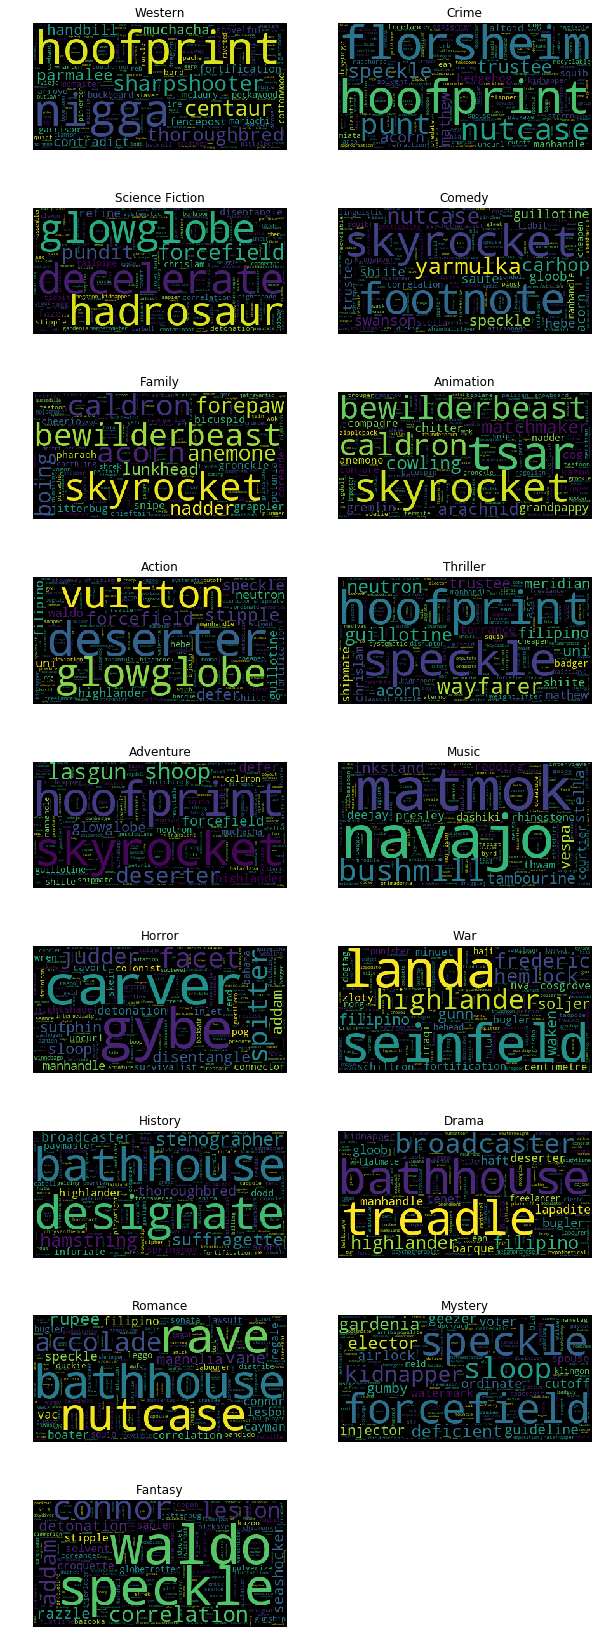

In [39]:
plt.figure(figsize=(10,30))

for i,row in enumerate(TF_IDF_matrix):
    genre = list(all_genres_scripts.keys())[i]
    TF_IDF_string = getWordStringForGenre(row)
    
    # Create the word cloud
    wordcloud = WordCloud().generate(TF_IDF_string)
    plt.subplot(math.ceil(len(genres_subset)/2),2,i+1)
    img=plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(genre)

plt.show()   

** Some thought**
 
We only have manuscripts for small subset of the movies in our database therefore there is a margin of error in these analysis. The result of the TF-IDF analysis is not as we would have expected from the get go. 

Here we will not go into depth in the analysis of these wordclouds because they do not give us valuable information about how to improve our recommendation engine and we did not consider the result to be that interesting.

# Conclusions  - Some final thoughts in the end 

We did a lot of analysis on the manuscripts, the initial idea was to use these findings as a variable into the recommendation engine. We did not manage to find manuscripts for all of the movies in our dataset and therefore we did not think that it would be a good idea to use this information in the recommendation engine. 
 
That being said, we consider these analysis to be a proof of concept, we have proven that the result of a sentiment analysis of the manuscripts could be used as a variable into a recommendation engine. For example both the mean sentiment value of a movie's manuscript and the variance of the sentiment values of the movie's manuscripts provide useful information about what kind of a movie we are talking about. For example if the mean sentiment value is high then the movie is most likely a so called 'feel good movie' and we could recommend movies that have similar mean sentiment values. Likewise we have discussed how the  variance of the sentiments give a valuable information about the movie, if the variance is high then there is a lot of contradictions in the storyline meaning for example that the movie is either a dark movie that has some happy moments in it (romance or comedy) or that the movie is a dark comedy.

So for further development of the recommendation engine we could've spent more time on finding more manuscripts for the movies or we could've downloaded the subtitles for each movie which should provide us with similar information about the movie. 


# Keyword analysis

The Kaggle dataset contains keywords for each movie. What we wanted to do next is to visualize these keywords in a wordcloud for each movie genre. 

We also wanted to analyze which keywords seem to be most popular. Therefore we will visualize the popularity of the keywords in a histogram. 

** Get data**

In [40]:
genres_keywords = defaultdict(list)
keyword_frequency = defaultdict(int)

for title in tmdb_5000_movies.keys():
    
    try:
        # Find the keywords for the movie
        keywords = [keyword['name'] for keyword in tmdb_5000_movies[title]['keywords']]

        # Find the genres of the movie
        genres = [genre for genre in [genre['name'] for genre in tmdb_5000_movies[title]['genres']]]

        # Add each keyword into the keyword_frequency dictionary
        for keyword in keywords:
            keyword_frequency[keyword] += 1
        
        # Add the keywords into the dictionary for each genre
        for genre in genres:
            for keyword in keywords:
                genres_keywords[genre].append(keyword)
    except:
        print ("The movie {} does not contain keywords in the database".format(title))

** Keyword frequency histogram**

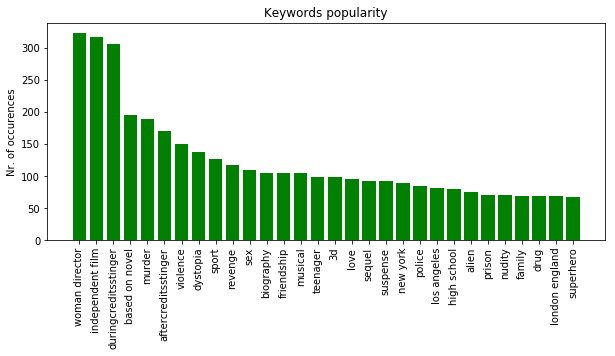

In [42]:
# sort the keyword dictionary, we only visualize the 30 most frequenct keywords
keywords_top30 = sorted(keyword_frequency.items(),key = operator.itemgetter(1), reverse=True)[0:30]

x,y = zip(*keywords_top30)

# Create a histogram of the keywords
plt.figure(figsize=(10,4))
plt.bar(range(len(x)), y, color="green")
plt.xticks( range(len(x)), x, rotation=90 )
plt.ylabel("Nr. of occurences")
plt.title("Keywords popularity")

plt.show()

**Some thougths**

- It is interesting to see that women director is the most common keyword. It seems to be quite important to illustrate the fact that it was actually a women that directed the movie. This again (we have seen this multiple times in the analysis) shows how male dominant this industry is. The fact that a woman directs the movie seems to be considered as a special feature of the movie and the movie producers think that it is important to illustrate that fact by having it as a keyword of the movie.

- Everything else seems to be like one could expect. The cities 'New York', 'Los Angeles' and 'London' are also higly used keywords which illustrates the fact that most movies are suppose to occur in these cities.

- Sex and love are also on the list which is not surprising, we all know that humans like to watch movies that involve love and sex scenes. More interestingly is to see that violence, revenge and murder are more frequently used than love and sex. 

Now we use the wordcloud module to create a beautiful wordcloud image of these keywords for each genre.

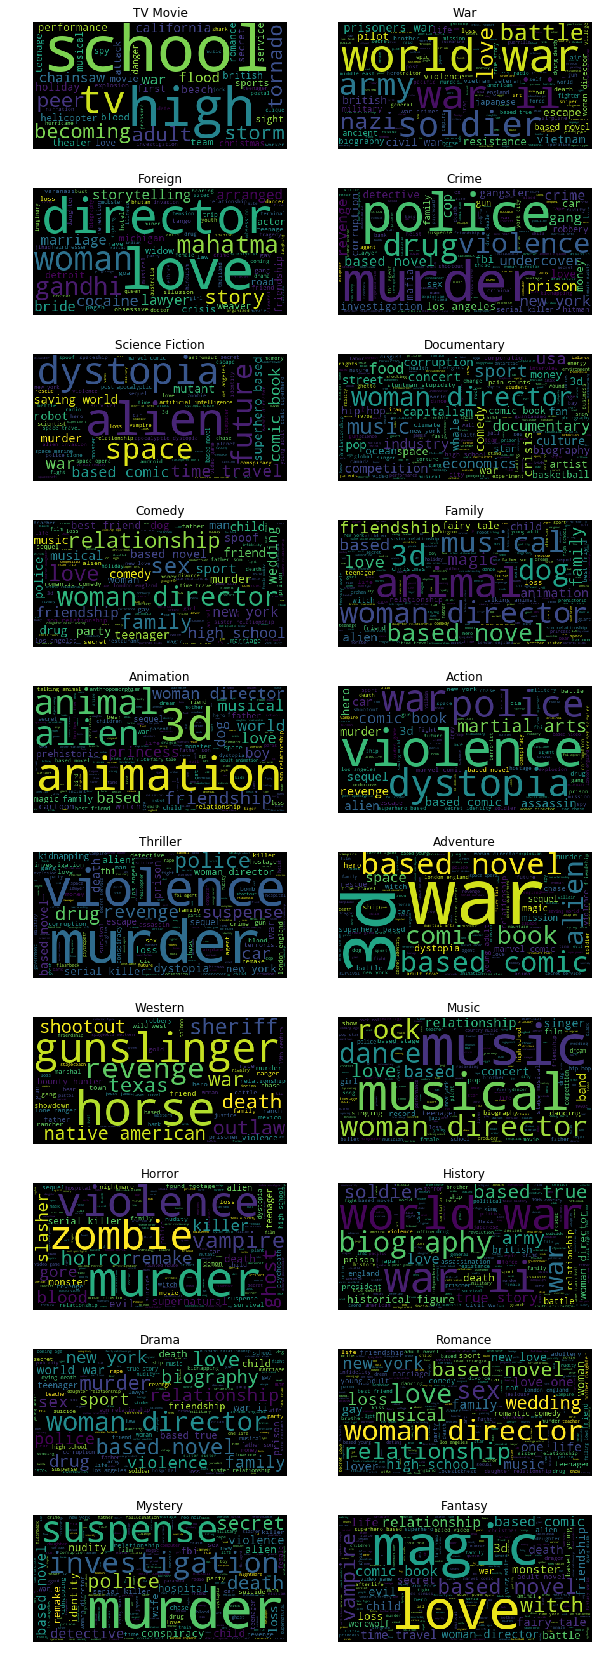

In [43]:
plt.figure(figsize=(10,30))

# There are certain words that we do not want to include therefore we leave them out
leave_out_words = ["duringcreditsstinger", "aftercreditsstinger", "independent film", "film"]

for i,key in enumerate(genres_keywords):
    # create the input string for the word cloud
    input_string = ' '.join(word for word in genres_keywords[key] if word not in leave_out_words)
    
    # Create the word cloud
    wordcloud = WordCloud().generate(input_string)
    plt.subplot(math.ceil(len(genres_keywords)/2),2,i+1)
    img=plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(key)

plt.show()

** Some thoughts**
- This was done more for fun than for some analytical purpose. 
- It is interesting to see that woman director is frequenctly used keyword in comedies and romance movies.
- Love is frequently used in Fantasy movies, this caught our attention and is an iteresting find.
- Most of the romantic movies seem to occur in New York.
- Everythink else is quite like you would expect, it is quite fun to see what keywords are used most frequenctly in each genre. I encourage an interested reader to take a look at these wordclouds.